In [1]:
!pip install keras-nlp --upgrade
!pip install nltk
!pip install statsmodels

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np
import pandas as pd
import re
import string
import nltk
import time
from transformers import DistilBertTokenizer, TFDistilBertModel, pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
import keras_nlp
from tensorflow.keras import backend as K
from keras import losses, optimizers
from keras.models import Model
from keras import layers
from keras.layers import Input, GlobalAveragePooling1D, Dense, Dropout, Concatenate, BatchNormalization
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.corpus import wordnet

# download nltk tokens
nltk.download('stopwords')
nltk.download('wordnet')
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/a-real-disaster-leaked-label/__results__.html
/kaggle/input/a-real-disaster-leaked-label/submission.csv
/kaggle/input/a-real-disaster-leaked-label/__resultx__.html
/kaggle/input/a-real-disaster-leaked-label/__notebook__.ipynb
/kaggle/input/a-real-disaster-leaked-label/__output__.json
/kaggle/input/a-real-disaster-leaked-label/custom.css
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json

### Import data

In [3]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_labels = pd.read_csv('/kaggle/input/a-real-disaster-leaked-label/submission.csv')

### Set seed

In [4]:
SEED = 42
tf.random.set_seed(SEED)

### Check GPU availability

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.is_gpu_available():
    print("Using GPU")

Num GPUs Available:  1
Using GPU


# 0.5. Our Target

##### We are supposed to make a model (or models) that perform better in prediction (or for f1 score) than applying DistilBert model to the raw test data.

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

def f1_score(y_true, y_pred):
    if y_pred.shape[-1]>1:
        y_pred_classes = tf.argmax(y_pred, axis=-1)
    else:
        y_pred_classes = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred_classes = tf.cast(y_pred_classes, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred_classes)
    fp = tf.reduce_sum((1 - y_true) * y_pred_classes)
    fn = tf.reduce_sum(y_true * (1 - y_pred_classes))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

def make_distilbert(seq_len=160, summary=True):
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset('distil_bert_base_en_uncased', sequence_length=seq_len, name="preprocessor_4_tweets")
    distilbert_model = keras_nlp.models.DistilBertClassifier.from_preset('distil_bert_base_en_uncased', preprocessor=preprocessor, num_classes=2)
    if summary: distilbert_model.summary()
    return distilbert_model

def distilbert_compile(distilbert_model, batch_size=32, epochs=2, plots=True):
    distilbert_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizers.Adam(1e-5), metrics=['accuracy', f1_score])
    history = distilbert_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], validation_data=(X_val, y_val))
    if plots:
        history_df = pd.DataFrame(data=history.history)
        history_df.loc[:, ['loss', 'val_loss']].plot()
        history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
        history_df.loc[:, ['f1_score', 'val_f1_score']].plot()

# for any model with the function "predict"
def print_metrics(model, X_train, X_test):
    y_train = train['target']
    y_test = test_labels['target']
    
    train_pred = model.predict(X_train)
    if train_pred.shape[-1] > 1:  # If using softmax
        train_pred = np.argmax(train_pred, axis=1)
    else:
        train_pred = (train_pred > 0.5).astype(int)
        
    train_acc = accuracy_score(y_train, train_pred)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = 2*train_precision*train_recall/(train_precision+train_recall)
    
    test_pred = model.predict(X_test)
    if test_pred.shape[-1] > 1:  # If using softmax
        test_pred = np.argmax(test_pred, axis=1)
    else:
        test_pred = (test_pred > 0.5).astype(int)
        
    test_acc = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = 2*test_precision*test_recall/(test_precision+test_recall)
    
    
    print(f"Train metrics: f1 score: {train_f1}, accuracy: {train_acc}")
    print(f"Test metrics:  f1 score: {test_f1}, accuracy: {test_acc}")
    return test_f1

In [7]:
# distilbert_model = make_distilbert()
# X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)
# X_test = test['text']

In [8]:
# %%time
# distilbert_compile(distilbert_model, plots=False)

In [9]:
# first_f1 = print_metrics(distilbert_model, X_train, X_test)

##### **The mission is to make a model with better performance (greater f1 score) than above.**

# 1. EDA

In [10]:
train.describe, test.describe

(<bound method NDFrame.describe of          id keyword location  \
 0         1     NaN      NaN   
 1         4     NaN      NaN   
 2         5     NaN      NaN   
 3         6     NaN      NaN   
 4         7     NaN      NaN   
 ...     ...     ...      ...   
 7608  10869     NaN      NaN   
 7609  10870     NaN      NaN   
 7610  10871     NaN      NaN   
 7611  10872     NaN      NaN   
 7612  10873     NaN      NaN   
 
                                                    text  target  
 0     Our Deeds are the Reason of this #earthquake M...       1  
 1                Forest fire near La Ronge Sask. Canada       1  
 2     All residents asked to 'shelter in place' are ...       1  
 3     13,000 people receive #wildfires evacuation or...       1  
 4     Just got sent this photo from Ruby #Alaska as ...       1  
 ...                                                 ...     ...  
 7608  Two giant cranes holding a bridge collapse int...       1  
 7609  @aria_ahrary @TheTawniest

In [11]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Null values

In [12]:
print(f"Number of null values in id column: {sum(train['id'].isnull())}")
print(f"Number of null values in keyword column: {sum(train['keyword'].isnull())}")
print(f"Number of null values in location column: {sum(train['location'].isnull())}")
print(f"Number of null values in text column: {sum(train['text'].isnull())}")
print(f"Number of null values in target column: {sum(train['target'].isnull())}")

Number of null values in id column: 0
Number of null values in keyword column: 61
Number of null values in location column: 2533
Number of null values in text column: 0
Number of null values in target column: 0


In [13]:
print(f"Ratio of null values in keyword column: {sum(train['keyword'].isnull())/len(train)}")
print(f"Ratio of null values in location column: {sum(train['location'].isnull())/len(train)}")

Ratio of null values in keyword column: 0.008012610009194798
Ratio of null values in location column: 0.33272034677525286


# 2. Preprocessing

### Remove complete duplicates from training dataset

In [14]:
train = train.loc[train.drop('id', axis=1).drop_duplicates().index]

### Remove duplicates and modify wrong labels 

#### Text duplicates

In [15]:
duplicates = train.groupby('text').size()
duplicates = duplicates[duplicates>1]
duplicates_df = train[train.text.isin(duplicates.index)]

# relabel
modify_texts = []
for index, row in duplicates_df.iterrows():
    for index2, row2 in duplicates_df.iterrows():
        if (not index==index2) and (row['text']==row2['text']) and (not row['target']==row2['target']):
            if not row['text'] in modify_texts:
                modify_texts.append(row['text'])
modify_map = {}
targets = [0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0]
for index, text in enumerate(modify_texts):
    modify_map[text] = targets[index]
    
def apply_modify_map(row):
    if row['text'] in modify_map.values():
        row['target'] = modify_map[row['text']]
    return row

train = train.apply(apply_modify_map, axis=1)
train = train.loc[train.drop('id', axis=1).drop_duplicates().index]

#### Manual modification for confusing words

In [16]:
# from nltk.stem import WordNetLemmatizer
# pd.set_option('display.max_colwidth', None)

# lem = WordNetLemmatizer()
# confusing_words = ['crush', 'crash', 'devastate', 'lava', 'injury', 'storm', 'abortion']
# temp_train = train.copy()
# temp_train['text'] = train['text'].apply(lambda text: ' '.join([lem.lemmatize(word) for word in text.split()]))
# temp_index = [temp_train[temp_train['text'].str.contains(word)].index.to_list() for word in confusing_words]
# temp_index = list(set(list(np.concatenate(temp_index))))
# temp_train = train.loc[temp_index]
# temp_train[temp_train['target']==1]

In [17]:
# Found a few tweets that are classified as 1 but should be 0
train.loc[train['id'].isin([328,443,513,2657,2619,2664,2692,2723,2743,2835,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]), 'target'] = 0

### Text Cleaning

##### The function "clean" is a code segment from [this notebook](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook) by [Gunes Evitan](https://www.kaggle.com/gunesevitan).

In [18]:
%%time

def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    return tweet

train['text'] = train['text'].apply(clean)
test['text'] = test['text'].apply(clean)

CPU times: user 6min 56s, sys: 107 ms, total: 6min 56s
Wall time: 6min 56s


### Lowercase

In [19]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

### Convert abbreviations & acronyms to normal words

In [20]:
# def aa_converter(text):
#     # abbreviations
#     abbreviation_mapping = {
#     "i'm": "i am",
#     "you're": "you are",
#     "we're": "we are",
#     "they're": "they are",
#     "it's": "it is",
#     "isn't": "is not",
#     "aren't": "are not",
#     "wasn't": "was not",
#     "weren't": "were not",
#     "can't": "cannot",
#     "couldn't": "could not",
#     "won't": "will not",
#     "wouldn't": "would not",
#     "don't": "do not",
#     "doesn't": "does not",
#     "didn't": "did not",
#     "hasn't": "has not",
#     "haven't": "have not",
#     "hadn't": "had not",
#     "i'd": "i would",
#     "you'd": "you would",
#     "he'd": "he would",
#     "she'd": "she would",
#     "we'd": "we would",
#     "they'd": "they would",
#     "i'll": "i will",
#     "you'll": "you will",
#     "he'll": "he will",
#     "she'll": "she will",
#     "we'll": "we will",
#     "they'll": "they will",
#     "i've": "i have",
#     "you've": "you have",
#     "we've": "we have",
#     "they've": "they have",
#     "who's": "who is",
#     "what's": "what is",
#     "where's": "where is",
#     "when's": "when is",
#     "why's": "why is",
#     "how's": "how is",
#     "let's": "let us",
#     "that's": "that is",
#     "there's": "there is",
#     "here's": "here is",
#     "shouldn't": "should not",
#     "wouldn't": "would not",
#     "couldn't": "could not",
#     "mustn't": "must not",
#     "mightn't": "might not",
#     "needn't": "need not",
#     "oughtn't": "ought not",
#     "sha'n't": "shall not",
#     "shan't": "shall not",
#     "ain't": "is not",
#     "daren't": "dare not",
#     "ma'am": "madam",
#     "o'clock": "of the clock",
#     "y'all": "you all",
#     "gonna": "going to",
#     "wanna": "want to",
#     "gotta": "got to",
#     "kinda": "kind of",
#     "sorta": "sort of",
#     "lotta": "lot of",
#     "lemme": "let me",
#     "gimme": "give me",
#     "innit": "is it not",
#     "betcha": "bet you",
#     "c'mon": "come on",
#     "y'know": "you know",
#     "whatcha": "what are you",
#     "d'you": "do you",
#     "could've": "could have",
#     "should've": "should have",
#     "would've": "would have",
#     "might've": "might have",
#     "must've": "must have",
#     "how'd": "how did",
#     "how'll": "how will",
#     "when'd": "when did",
#     "where'd": "where did",
#     "who'd": "who would",
#     "what're": "what are",
#     "where're": "where are",
#     "why're": "why are",
#     "that'd": "that would",
#     "who're": "who are",
#     "they've": "they have",
#     "you've": "you have",
#     "she'd": "she had",
#     "he'd": "he had",
#     "it'd": "it would",
#     "we'll": "we will",
#     "it'll": "it will",
#     "we've": "we have",
#     "that'll": "that will",
#     "there'll": "there will",
#     "you'll": "you will",
#     "who'll": "who will",
#     "what'll": "what will",
#     "where'll": "where will",
#     "when'll": "when will",
#     "why'll": "why will",
#     "how'll": "how will",
#     }
    
#     # slangs
#     slang_mapping = {
#     "afaik": "as far as I know",
#     "afk": "away from keyboard",
#     "asap": "as soon as possible",
#     "atm": "at the moment",
#     "brb": "be right back",
#     "btw": "by the way",
#     "b4": "before",
#     "bff": "best friends forever",
#     "cuz": "because",
#     "cya": "see you",
#     "dm": "direct message",
#     "ftw": "for the win",
#     "fwiw": "for what it's worth",
#     "fyi": "for your information",
#     "gg": "good game",
#     "gl": "good luck",
#     "gtg": "got to go",
#     "gr8": "great",
#     "hbu": "how about you",
#     "hbd": "happy birthday",
#     "idc": "I don't care",
#     "idk": "I don't know",
#     "ikr": "I know, right",
#     "imo": "in my opinion",
#     "imho": "in my humble opinion",
#     "irl": "in real life",
#     "jk": "just kidding",
#     "lmao": "laughing my ass off",
#     "lmfao": "laughing my fucking ass off",
#     "lol": "laugh out loud",
#     "nvm": "never mind",
#     "omg": "oh my god",
#     "omw": "on my way",
#     "ppl": "people",
#     "rofl": "rolling on the floor laughing",
#     "smh": "shaking my head",
#     "tbh": "to be honest",
#     "tfw": "that feeling when",
#     "thx": "thanks",
#     "tho": "though",
#     "tldr": "too long; didn't read",
#     "ttyl": "talk to you later",
#     "ty": "thank you",
#     "w/e": "whatever",
#     "w/o": "without",
#     "wbu": "what about you",
#     "wtf": "what the fuck",
#     "wth": "what the hell",
#     "xoxo": "hugs and kisses",
#     "yolo": "you only live once",
#     "b4n": "bye for now",
#     "bc": "because",
#     "bday": "birthday",
#     "bf": "boyfriend",
#     "gf": "girlfriend",
#     "bff": "best friends forever",
#     "brb": "be right back",
#     "btw": "by the way",
#     "cu": "see you",
#     "diy": "do it yourself",
#     "ftw": "for the win",
#     "irl": "in real life",
#     "jk": "just kidding",
#     "l8r": "later",
#     "lmk": "let me know",
#     "msg": "message",
#     "nbd": "no big deal",
#     "ngl": "not gonna lie",
#     "np": "no problem",
#     "omg": "oh my god",
#     "plz": "please",
#     "rofl": "rolling on the floor laughing",
#     "srsly": "seriously",
#     "tmi": "too much information",
#     "ttyl": "talk to you later",
#     "wyd": "what you doing",
#     "zzz": "sleeping",
#     }
    
#     for slang, orig in slang_mapping.items():
#         text = re.sub(slang, orig, text)
#     for abbrev, orig in abbreviation_mapping.items():
#         text = re.sub(abbrev, orig, text)
#     return text

# train['text'] = train['text'].apply(aa_converter)
# test['text'] = test['text'].apply(aa_converter)

### Remove excessive space

In [21]:
train['text'] = train['text'].apply(lambda text: re.sub(r'\s\s+', ' ', text))
test['text'] = test['text'].apply(lambda text: re.sub(r'\s\s+', ' ', text))

# 2.5. DistilBert w/o Features after Cleaning Texts

In [22]:
# distilbert_cleaned = make_distilbert()
# X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)
# X_test = test['text']

In [23]:
# %%time
# distilbert_compile(distilbert_cleaned, epochs=10)

##### Choose epoch **2**

In [24]:
# tf.keras.backend.clear_session()
# distilbert_cleaned = make_distilbert(summary=False)
# distilbert_compile(distilbert_cleaned, epochs=2, plots=False)
# second_f1 = print_metrics(distilbert_cleaned, X_train, X_test)

In [25]:
# second_f1-first_f1

# 3. Feature Engineering

### One-hot encoding

In [26]:
print(f"Number of unique keywords: {len(train['keyword'].unique())}")
print(f"Number of unique locations: {len(train['location'].unique())}")

Number of unique keywords: 222
Number of unique locations: 3342


- We can one-hot encode the keyword column regardless of the importance while we need to **select the appropriate locations** to consider since there are too many unique locations.

#### keyword

In [27]:
# Fill null values with null
train['keyword'] = train['keyword'].fillna('null')
test['keyword'] = test['keyword'].fillna('null')

In [28]:
# One-hot encoding for keyword column
enc = OneHotEncoder(sparse=False).fit(np.array(train['keyword']).reshape(-1, 1))
train_keywords = enc.transform(np.array(train['keyword']).reshape(-1, 1))
test_keywords = enc.transform(np.array(test['keyword']).reshape(-1, 1))
keyword_names = enc.get_feature_names_out()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### location

In [29]:
# Fill null values with unknown
train['location'] = train['location'].fillna('unknown')
test['location'] = test['location'].fillna('unknown')

In [30]:
# EDA for the location column
NUM_FREQ = 4
location_frequencies = train.groupby('location').size()
location_frequencies = location_frequencies[location_frequencies>=NUM_FREQ]
print(f"Number of locations that apppear more than {NUM_FREQ} times: {len(location_frequencies)}")
location_frequencies

Number of locations that apppear more than 4 times: 154


location
 Road to the Billionaires Club       6
304                                  9
?                                    4
??                                   4
?????                                4
                                  ... 
in the Word of God                   5
london                               4
ss                                  10
unknown                           2500
worldwide                            7
Length: 154, dtype: int64

- Feature Length 106 is acceptable

In [31]:
# one-hot encoding for selected locations
enc = OneHotEncoder(sparse=False, categories=[location_frequencies.index.to_list()], handle_unknown='ignore').fit(np.array(train['location']).reshape(-1, 1))
train_locations = enc.transform(np.array(train['location']).reshape(-1, 1))
test_locations = enc.transform(np.array(test['location']).reshape(-1, 1))
location_names = enc.get_feature_names_out()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
train_features = pd.DataFrame()
test_features = pd.DataFrame()

### Text length

In [33]:
train_features['text_length'] = train['text'].str.split().apply(len)
train_features['text_length'] = train_features['text_length'].apply(lambda x: (x-np.mean(train_features['text_length']))/np.std(train_features['text_length']))

test_features['text_length'] = test['text'].str.split().apply(len)
test_features['text_length'] = test_features['text_length'].apply(lambda x: (x-np.mean(test_features['text_length']))/np.std(test_features['text_length']))

### Sentiment Score

In [34]:
%%time

sentiment_pipeline = pipeline("sentiment-analysis")

train_features['sentiment'] = train['text'].apply(lambda x: sentiment_pipeline(x)[0]['score'])
test_features['sentiment'] = test['text'].apply(lambda x: sentiment_pipeline(x)[0]['score'])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


CPU times: user 11min 30s, sys: 4.01 s, total: 11min 34s
Wall time: 5min 48s


### Hashtags

In [35]:
train_features['hashtag_nums'] = train['text'].apply(lambda text: len(re.findall(r'#\S+', text)))
test_features['hashtag_nums'] = test['text'].apply(lambda text: len(re.findall(r'#\S+', text)))

### Keyword density

In [36]:
def keyword_density(text, keywords):
    count = sum(1 for keyword in text.split() if keyword in keywords)
    return count/len(text.split())
train_features['keyword_density'] = train['text'].apply(lambda text: keyword_density(text, train['keyword'].unique()))
test_features['keyword_density'] = test['text'].apply(lambda text: keyword_density(text, train['keyword'].unique()))

# 4. Backward Elimination

In [37]:
%%time

import statsmodels.api as sm

def backward_elimination(train_data, test_data, train_target, p=0.05):
    while True:
        ols = sm.OLS(train_target, train_data).fit()
        max_p_value = max(ols.pvalues[1:])
        if max_p_value < p:
            break
        max_p_idx = ols.pvalues[1:].argmax()+1
        train_data = np.delete(train_data, max_p_idx, axis=1)
        test_data = np.delete(test_data, max_p_idx, axis=1)
    print(ols.summary())
    
    # remove constant column
    train_data = np.delete(train_data, 0, axis=1)
    test_data = np.delete(test_data, 0, axis=1)
    return train_data, test_data

train_feature_stack = np.hstack([train_keywords, train_locations, np.array(train_features)])
test_feature_stack = np.hstack([test_keywords, test_locations, np.array(test_features)])

# train_feature_stack = sm.add_constant(train_feature_stack)
# test_feature_stack = sm.add_constant(test_feature_stack)
# train_feature_stack, test_feature_stack = backward_elimination(train_feature_stack, test_feature_stack, train['target'])

CPU times: user 901 ms, sys: 101 ms, total: 1 s
Wall time: 1.36 s


In [38]:
train_feature_stack.shape, test_feature_stack.shape

((7561, 380), (3263, 380))

# 5. DistilBert Embeddings

In [39]:
%%time

def get_embeddings(texts, tokenizer, model, batch=32, max_len=160):
    embeddings = []
    for i in range(0, len(texts), batch):
        batch_texts = texts[i:i+batch]
        inputs = tokenizer(batch_texts.to_list(), return_tensors='tf', padding=True, truncation=True, max_length=max_len)
        outputs = model(inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].numpy())
    return np.vstack(embeddings)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
db = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
train_embeddings = get_embeddings(train['text'], tokenizer, db)
test_embeddings = get_embeddings(test['text'], tokenizer, db)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


CPU times: user 42.2 s, sys: 1.14 s, total: 43.4 s
Wall time: 45.9 s


In [40]:
train_embeddings.shape, test_embeddings.shape

((7561, 768), (3263, 768))

# 6. Finalize Datasets

# 7. Model

### Model definition

In [41]:
def wrapper_model(dim_embs, dim_features, max_len=160, summary=True):
    # embeddings
    emb_input = Input(shape=(dim_embs,), dtype=tf.float32, name="embeddings_input")
    text_dense = Dense(128, activation='relu')(emb_input)
    text_dense = Dropout(0.3)(text_dense)

    # features
    feature_input = Input(shape=(dim_features,), name='feature_input')
    feature_dense = Dense(32, activation='relu')(feature_input)
    feature_dense = Dropout(0.3)(feature_dense)

    # all together
    concatenated = Concatenate(axis=1)([text_dense, feature_dense])
    dense_1 = Dense(128, activation='relu')(concatenated)
    dense_1 = Dropout(0.3)(dense_1)
    dense_1 = BatchNormalization()(dense_1)

    dense_2 = Dense(64, activation='relu')(dense_1)
    dense_2 = Dropout(0.3)(dense_2)
    dense_2 = BatchNormalization()(dense_2)
    
    output = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=[emb_input, feature_input], outputs=output)
    if summary:
        model.summary()
    return model

def wrapper_compile(model, X_embeddings, X_features, y, l_rate=1e-3, batch_size=32, epochs=3, plots=True):
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    X_emb_train, X_emb_val, X_fea_train, X_fea_val, y_train, y_val = train_test_split(X_embeddings, X_features, y, test_size=0.2, random_state=SEED)
    model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer=optimizers.Adam(l_rate), metrics=['accuracy', f1_score])
    history = model.fit([X_emb_train, X_fea_train], y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], validation_data=([X_emb_val, X_fea_val], y_val))
    if plots:
        history_df = pd.DataFrame(data=history.history)
        history_df.loc[:, ['loss', 'val_loss']].plot()
        history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
        history_df.loc[:, ['f1_score', 'val_f1_score']].plot()
        
def wrapper_compile_cheat(model, X_embeddings, X_features, X_test_embeddings, X_test_features, y, l_rate=1e-3, batch_size=32, epochs=3, plots=True):
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer=optimizers.Adam(l_rate), metrics=['accuracy', f1_score])
    history = model.fit([X_embeddings, X_features], y, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], validation_data=([X_test_embeddings, X_test_features], test_labels['target']))
    if plots:
        history_df = pd.DataFrame(data=history.history)
        history_df.loc[:, ['f1_score', 'val_f1_score']].plot()

### Hyperparameter tuining (learning rate and epochs)

===========learning rate: 0.0001===========
Epoch 1/50


I0000 00:00:1728373909.441526      85 service.cc:145] XLA service 0x7fb2d00033f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728373909.441582      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 80/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - f1_score: 0.4880 - loss: 0.8272

I0000 00:00:1728373915.334515      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5608 - f1_score: 0.5145 - loss: 0.7832 - val_accuracy: 0.7376 - val_f1_score: 0.5737 - val_loss: 0.5590
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - f1_score: 0.6269 - loss: 0.6253 - val_accuracy: 0.7687 - val_f1_score: 0.6797 - val_loss: 0.4822
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7426 - f1_score: 0.6849 - loss: 0.5577 - val_accuracy: 0.7766 - val_f1_score: 0.6816 - val_loss: 0.4695
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7601 - f1_score: 0.7014 - loss: 0.5271 - val_accuracy: 0.7806 - val_f1_score: 0.6832 - val_loss: 0.4656
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - f1_score: 0.7016 - loss: 0.5167 - val_accuracy: 0.7978 - val_f1_score: 0.7215 - val_loss: 0.4496
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7739 - f1_score: 0.7120 - loss: 0.5076 - val_accuracy: 0.7865 - val_f1_score: 0.6855 - val_loss

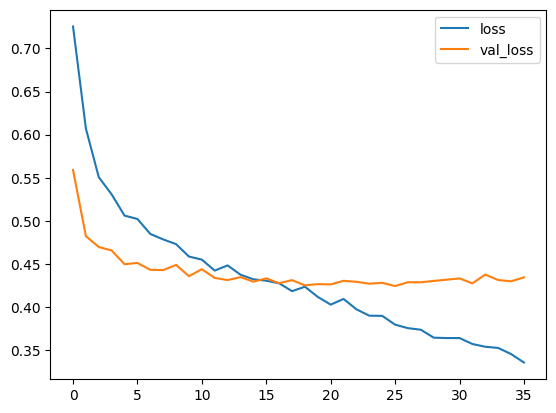

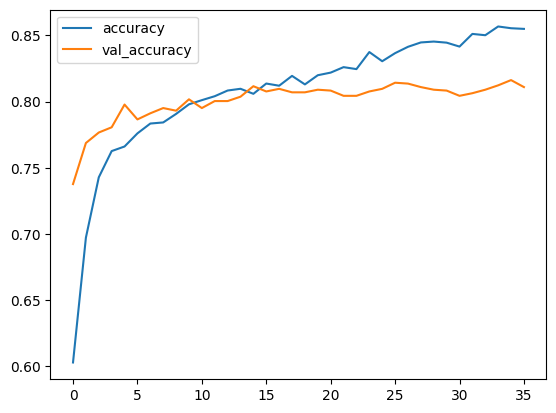

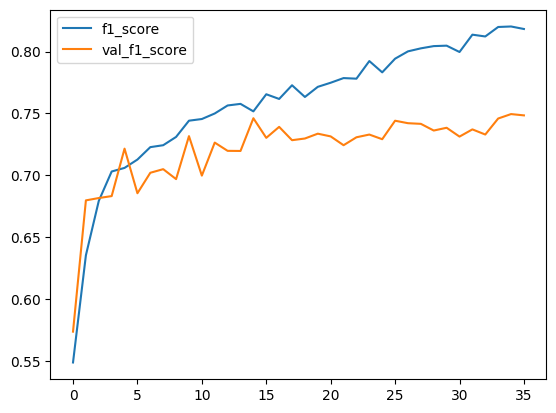

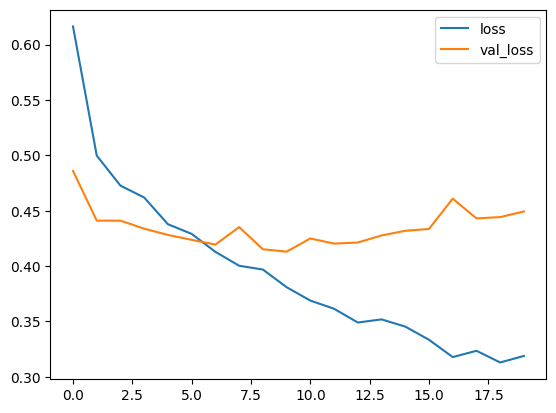

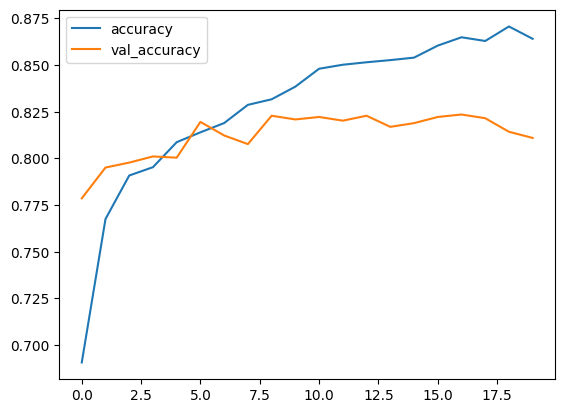

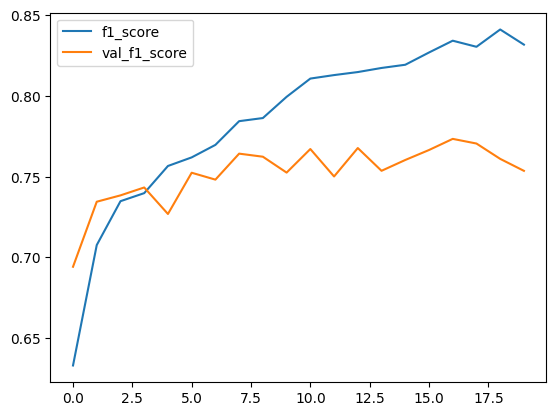

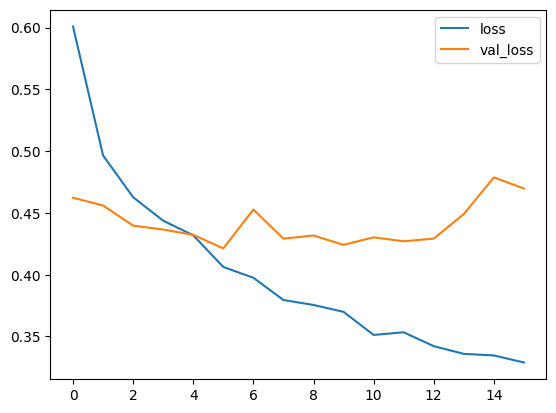

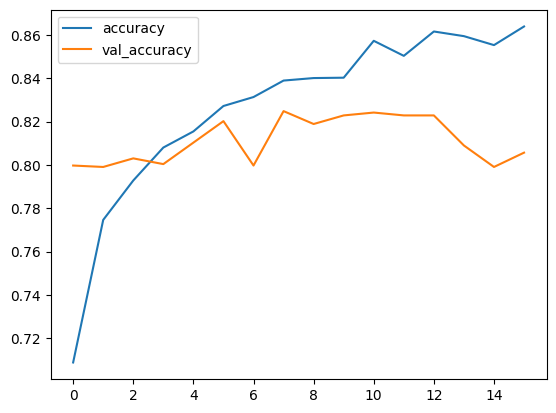

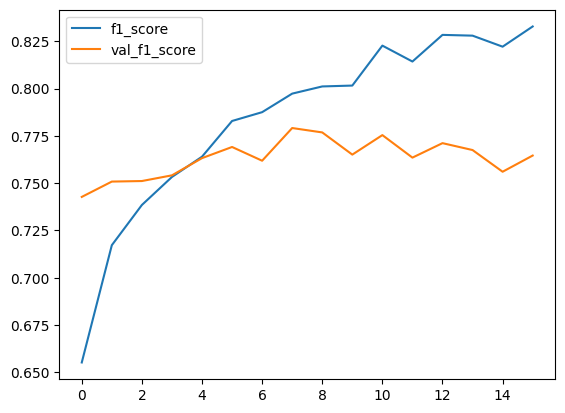

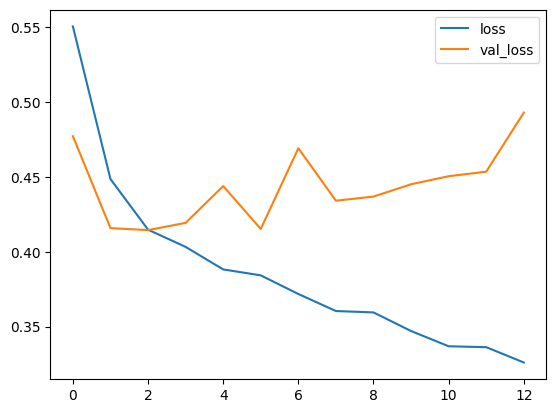

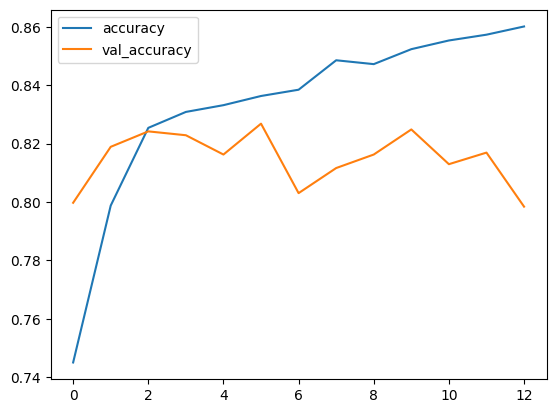

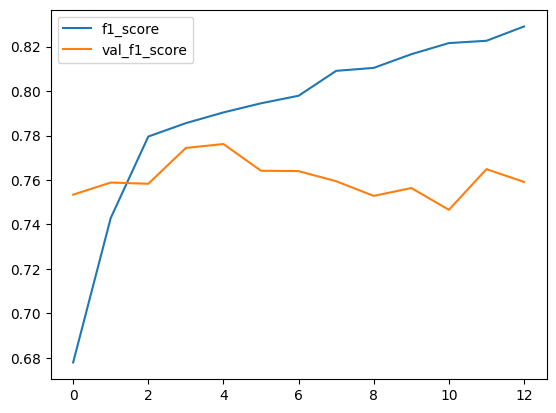

In [42]:
for l_rate in [1e-4, 5e-4, 1e-3, 5e-3]:
    tf.keras.backend.clear_session()
    print(f"===========learning rate: {l_rate}===========")
    model = wrapper_model(train_embeddings.shape[-1], train_feature_stack.shape[1], summary=False)
    wrapper_compile(model, train_embeddings, train_feature_stack, train['target'], l_rate=l_rate, epochs=50)
    #wrapper_compile_cheat(model, train_embeddings, train_feature_stack, test_embeddings, test_feature_stack, train['target'], l_rate=l_rate, epochs=50)

- choose learning rate: 5e-3, epochs: 6

In [43]:
model = wrapper_model(train_embeddings.shape[-1], train_feature_stack.shape[1])
wrapper_compile(model, train_embeddings, train_feature_stack, train['target'], l_rate=5e-3, epochs=8, plots=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings_input    │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 380)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     98,432 │ embeddings_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │     12,192 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     20,608 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_7[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,321 (548.13 KB)

 Trainable params: 139,937 (546.63 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6929 - f1_score: 0.6371 - loss: 0.6283 - val_accuracy: 0.8011 - val_f1_score: 0.7465 - val_loss: 0.4658
Epoch 2/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - f1_score: 0.7479 - loss: 0.4546 - val_accuracy: 0.8037 - val_f1_score: 0.7610 - val_loss: 0.4488
Epoch 3/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8234 - f1_score: 0.7803 - loss: 0.4190 - val_accuracy: 0.8229 - val_f1_score: 0.7624 - val_loss: 0.4104
Epoch 4/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - f1_score: 0.7951 - loss: 0.3960 - val_accuracy: 0.8143 - val_f1_score: 0.7664 - val_loss: 0.4216
Epoch 5/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - f1_score: 0.8037 - loss: 0.3849 - val_accuracy: 0.8182 - val_f1_score: 0.7615 - val_loss: 0.4221
Epoch 6/8
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - f1_score: 0.8062 - loss: 0.3713 - val_accuracy: 0.8156 - val_f1_score: 0.7567 - val

In [44]:
final_f1 = print_metrics(model, X_train=[train_embeddings, train_feature_stack], X_test=[test_embeddings, test_feature_stack])

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train metrics: f1 score: 0.8049232844377002, accuracy: 0.8469779129744742
Test metrics:  f1 score: 0.7627580833657966, accuracy: 0.8133619368679129


In [45]:
submission = test[['id']].copy()
submission['target'] = list(np.concatenate(model.predict([test_embeddings, test_feature_stack]).tolist()))
submission['target'] = (submission['target']>0.5).astype('int')
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### test set optimization

task: check mispredictions to identify the patterns current model can't detect

In [46]:
temp_test = pd.merge(test, test_labels, on='id')
test_pred = model.predict([test_embeddings, test_feature_stack])
if test_pred.shape[-1] > 1:
    test_pred = np.argmax(test_pred, axis=1)
else:
    test_pred = (test_pred > 0.5).astype(int)
    
temp_test['prediction'] = test_pred
temp_test['incorrect'] = temp_test['target']+temp_test['prediction']==1
len(temp_test[temp_test['incorrect']])/len(temp_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.18663806313208703

In [47]:
temp_test[temp_test['incorrect']].head()

,id,keyword,location,text,target,prediction,incorrect
17,51,ablaze,NIGERIA,# previouslyondoyintv : toke makinwas marriag...,0,1,True
25,87,ablaze,"scarborough, ontario",@ ctvtoronto the bins in front of the field b...,0,1,True
27,90,ablaze,"121 N La Salle St, Suite 500",' burning rahm ' : let us hope city hall buil...,0,1,True
33,108,accident,Massachusetts,coincidence or # curse ? still # unresolved se...,0,1,True
36,116,accident,unknown,for legal and medical referral service @ 1800_...,0,1,True


In [48]:
incorrect = temp_test[temp_test['incorrect']]
inc_keywords = incorrect.groupby('keyword').size().sort_values(ascending=False)
inc_keywords[inc_keywords>5]

keyword
bioterrorism           10
first%20responders     10
collapse                9
heat%20wave             9
annihilation            8
avalanche               8
mass%20murderer         7
buildings%20burning     7
mass%20murder           7
crashed                 7
deaths                  6
collapsed               6
storm                   6
snowstorm               6
devastation             6
riot                    6
nuclear%20reactor       6
hazard                  6
flood                   6
detonation              6
drowning                6
dtype: int64

In [49]:
inc_ratio = (inc_keywords/test.groupby('keyword').size().sort_values(ascending=False)[inc_keywords.index]).sort_values(ascending=False)
inc_ratio[inc_ratio>0.4]

keyword
threat                 0.600000
collapse               0.562500
heat%20wave            0.562500
mass%20murderer        0.500000
deaths                 0.500000
bioterrorism           0.500000
first%20responders     0.476190
buildings%20burning    0.466667
crashed                0.437500
nuclear%20reactor      0.428571
devastation            0.428571
mass%20murder          0.411765
dtype: float64

In [50]:
temp_test[temp_test['keyword']=='threat']

,id,keyword,location,text,target,prediction,incorrect
2883,9543,threat,"Baton Rouge, LA",@ szuniverse no threat of that sir . . . for ...,0,0,False
2884,9544,threat,unknown,white space devices pose threat to medical dev...,0,0,False
2885,9545,threat,"San Francisco, CA",a reminder : white americans are the biggest t...,0,1,True
2886,9546,threat,unknown,angry orchard hard cider recalled due to threa...,1,0,True
2887,9549,threat,"Portland, Oregon, USA",most popular content top story : barrel bombs ...,1,0,True


In [51]:
train[train['keyword']=='threat']

,id,keyword,location,text,target
6659,9542,threat,Everywhere,build and share your own custom applications a...,0
6660,9547,threat,unknown,is this the end of australias best burger ? vi...,0
6661,9548,threat,Hyrule,@ kinggerudo_ to the largest moblin ' s he ' ...,0
6662,9550,threat,front row at a show,white americans are the biggest threat in the ...,0
6663,9551,threat,"Ohio, USA",the few i warned about . . were just as i expe...,0
6664,9552,threat,"London, UK",generational british schism over privacy threa...,0
6665,9553,threat,"Arlington, VA",get access to the most extensive sources of th...,0
6666,9554,threat,God.Family.Money,if a nigga was a threat then that boy ah be th...,0
6667,9555,threat,Everywhere,purple heart vet finds jihad threat on his car...,0
6668,9556,threat,"Kwajalein/Virginia/Dayton, OH",@ dmassa5 definite triple crown threat . him ...,1
